## Cuisine classification

In [3]:
!head sample_submission.csv

Id,cuisine
24888,italian
43564,italian
21898,italian
6991,italian
37700,italian
43546,italian
20544,italian
14160,italian
21405,italian


In [8]:
import json
with open('cooking_train.json') as f:
    trainset = json.load(f)

print(len(trainset))
print(trainset[:1])

30000
[{'ingredients': ['romaine lettuce', 'sliced almonds', 'vegetable oil', 'scallions', 'soy sauce', 'cooked chicken', 'napa cabbage', 'chopped cilantro fresh', 'sugar', 'sesame seeds', 'wonton wrappers', 'fresh lemon juice', 'white vinegar', 'black pepper', 'sesame oil', 'salt', 'snow peas'], 'cuisine': 'chinese', 'id': 29565}]


#### Let's see what labels we have

In [33]:
from collections import Counter
import pandas as pd

labels = [meal['cuisine'] for meal in trainset]

cuisine_counter = Counter(labels)
cuisines_df = pd.DataFrame.from_dict(cuisine_counter, orient='index')

print(cuisines_df)

                 0
thai          1164
vietnamese     620
greek          898
brazilian      352
indian        2285
filipino       564
korean         616
japanese      1076
irish          498
cajun_creole  1160
jamaican       404
chinese       2014
moroccan       605
mexican       4886
spanish        741
russian        360
italian       5894
british        600
french        1983
southern_us   3280


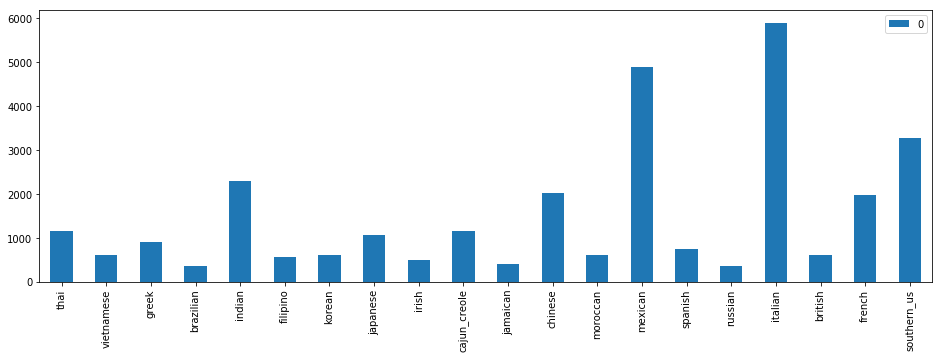

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

cuisines_df.plot(kind='bar', figsize=(16, 5))
plt.show()

### Let's check the list of ingredients

In [42]:
ingredients = []
for meal in trainset:
    ingredients.extend(meal['ingredients'])

ingredients_counter = Counter(ingredients)
ingredients_df = pd.DataFrame.from_dict(ingredients_counter, orient='index')
ingredients_df.columns = ['count']
print(ingredients_df.sort_values(by='count', ascending=False))

                              count
salt                          13681
olive oil                      6026
onions                         6024
water                          5604
garlic                         5574
sugar                          4811
garlic cloves                  4702
butter                         3684
ground black pepper            3591
all-purpose flour              3515
pepper                         3364
vegetable oil                  3319
eggs                           2582
soy sauce                      2463
tomatoes                       2323
kosher salt                    2302
green onions                   2295
large eggs                     2197
carrots                        2128
unsalted butter                2085
ground cumin                   2056
extra-virgin olive oil         2025
black pepper                   1955
milk                           1713
chili powder                   1552
oil                            1522
grated parmesan cheese      

## Possible approaches
* ensemble
* number of ingredients
* tf-idf
* one hot
* top ingredients
* polynomial features

# Model 1 - TFIDF on Linear SVC

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
ingredients_lists = [' '.join(meal['ingredients']) for meal in trainset]
vectorizer.fit(ingredients_lists)

def get_features(dataset):
    ingredients_lists = [' '.join(meal['ingredients']) for meal in dataset]
    X = vectorizer.transform(ingredients_lists)
    return X

def get_labels(dataset):
    y = np.array([meal['cuisine'] for meal in dataset])
    return y

In [180]:
X_train, y_train = get_features(trainset), get_labels(trainset)

### Shuffle data

In [181]:
dataset_size = len(y_train)
indices = np.random.permutation(dataset_size)
X_train = X_train[indices]
y_train = y_train[indices]

## TODO
* build the pipeline - validation, split, dumping results and the first model

In [182]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
classifier = LinearSVC()

In [183]:
from sklearn.model_selection import GridSearchCV
params = {'class_weight': ['balanced', None], 'C': [1, 2], 'fit_intercept': [False, True]}
grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=8, verbose=5, n_jobs=7)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 8 candidates, totalling 64 fits
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV]  fit_intercept=False, C=1, class_weight=balanced, score=0.7651757188498403, total=   2.3s
[CV] fit_intercept=False, C=1, class_weight=balanced .................
[CV]  fit_intercept=False, C=1, class_weight=balanced, score=0.7723642172523961, total=   3.0s
[CV]  fit_intercept=False, C=1, class_weight=balanced, score=0.7730420884389984, total=   3.0s
[CV] fit_intercept=True, C=1, class_weight=balanced ..................
[CV] fit_interce

[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    3.2s


[CV]  fit_intercept=False, C=1, class_weight=balanced, score=0.7608230892570818, total=   2.7s
[CV] fit_intercept=True, C=1, class_weight=balanced ..................
[CV]  fit_intercept=True, C=1, class_weight=balanced, score=0.7638445154419595, total=   3.5s
[CV] fit_intercept=True, C=1, class_weight=balanced ..................
[CV]  fit_intercept=True, C=1, class_weight=balanced, score=0.769271805814884, total=   4.2s
[CV] fit_intercept=False, C=1, class_weight=None .....................
[CV]  fit_intercept=True, C=1, class_weight=balanced, score=0.7744941427050053, total=   4.5s
[CV]  fit_intercept=True, C=1, class_weight=balanced, score=0.7741076185402238, total=   4.5s
[CV] fit_intercept=False, C=1, class_weight=None .....................
[CV] fit_intercept=False, C=1, class_weight=None .....................
[CV]  fit_intercept=True, C=1, class_weight=balanced, score=0.7637187000532765, total=   4.5s
[CV] fit_intercept=False, C=1, class_weight=None .....................
[CV]  fit_

In [173]:
from sklearn.metrics import classification_report
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7859
{'fit_intercept': True, 'class_weight': None, 'C': 1}


In [174]:
with open('cooking_test.json') as f:
    testset = json.load(f)

X_test = get_features(testset) 

In [175]:
y_test = best_classifier.predict(X_test)

In [176]:
ids = [item['id'] for item in testset]
results = pd.DataFrame.from_dict({'Id': ids, 'cuisine': y_test})
print(results.head())

      Id   cuisine
0  24888   italian
1  43564  moroccan
2  21898   italian
3   6991  moroccan
4  37700   spanish


In [177]:
with open('my_submission.csv', 'w') as res:
    results.to_csv(res, index=False)

In [178]:
!head my_submission.csv

Id,cuisine
24888,italian
43564,moroccan
21898,italian
6991,moroccan
37700,spanish
43546,southern_us
20544,chinese
14160,italian
21405,irish
